In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D, Input
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.activations import softmax

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

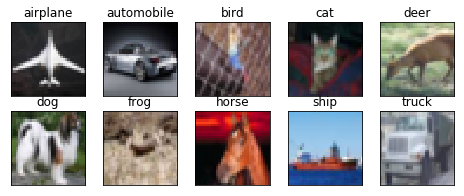

In [17]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Define the model

input = Input(shape=(32, 32, 3,))

layer1 = Conv2D(48, (3,3), padding='same', activation='relu', name='normal_conv_1', use_bias=False)(input) # 3

layer2n = BatchNormalization(name='norm2')(layer1)
layer2a = Conv2D(48, (3,1), padding='same', activation='relu', name='3x1_1', use_bias=False)(layer2n)
layer2b = Conv2D(48, (1,3), padding='same', activation='relu', name='1x3_1', use_bias=False)(layer2a) # 5

layer3n = BatchNormalization(name='norm3')(layer2b)
layer3 = SeparableConv2D(48, (3,3), padding='same', activation='relu', name='sep_conv_1', use_bias=False)(layer3n) # 7

layer4n = BatchNormalization(name='norm4')(layer3)
layer4a = Conv2D(48, (3,3), padding='same', activation='relu', name='group_3x3_1', use_bias=False)(layer4n) # 9
layer4b = Conv2D(48, (5,5), padding='same', activation='relu', name='group_5x5_1', use_bias=False)(layer4n) # 11
concat1 = concatenate([layer4a, layer4b])

layer5n = BatchNormalization(name='norm5')(concat1)
layer5a = Conv2D(48, (3,3), dilation_rate=(1,1), padding='same', activation='relu', name='dilate_1x1_1', use_bias=False)(layer5n) # 11, 13
layer5b = Conv2D(48, (3,3), dilation_rate=(2,2), padding='same', activation='relu', name='dilate_2x2_1', use_bias=False)(layer5n) # 13, 15 
concat2 = concatenate([layer5a, layer5b])

layer6n = BatchNormalization(name='norm6')(concat2)
layer6 = Conv2D(96, (1,1), padding='same', activation='relu', name='1x1_96', use_bias=False)(layer6n) # 11-15

layer_max1 = MaxPooling2D(pool_size=(2,2))(layer6) # 22, 26, 30

layer7n = BatchNormalization(name='norm7')(layer_max1)
layer7a = Conv2D(96, (3,3), padding='same', activation='relu', name='group_3x3_2', use_bias=False)(layer7n) # 24, 28, 32
layer7b = Conv2D(96, (5,5), padding='same', activation='relu', name='group_5x5_2', use_bias=False)(layer7n) # 26, 30, 34
concat3 = concatenate([layer7a, layer7b])

layer8n = BatchNormalization(name='norm8')(concat3)
layer8a = Conv2D(96, (3,3), dilation_rate=(1,1), padding='same', activation='relu', name='dilate_1x1_2', use_bias=False)(layer8n) # 26, 28, 30, 32, 34, 36
layer8b = Conv2D(96, (3,3), dilation_rate=(2,2), padding='same', activation='relu', name='dilate_2x2_2', use_bias=False)(layer8n) # 28, 30, 32, 34, 36, 38 
concat4 = concatenate([layer8a, layer8b])

layer9n = BatchNormalization(name='norm9')(concat4)
layer9 = Conv2D(num_classes, (16,16), use_bias=False, name='1x1_192')(layer9n) 

flatten = Flatten()(layer9)
output = Activation(softmax)(flatten)

model = Model(inputs=[input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
normal_conv_1 (Conv2D)          (None, 32, 32, 48)   1296        input_11[0][0]                   
__________________________________________________________________________________________________
norm2 (BatchNormalization)      (None, 32, 32, 48)   192         normal_conv_1[0][0]              
__________________________________________________________________________________________________
3x1_1 (Conv2D)                  (None, 32, 32, 48)   6912        norm2[0][0]                      
__________________________________________________________________________________________________
1x3_1 (Con

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 48s 124ms/step - loss: 2.0010 - acc: 0.4955 - val_loss: 3.4001 - val_acc: 0.4709
Epoch 2/50
390/390 [==============================] - 45s 116ms/step - loss: 1.1767 - acc: 0.6536 - val_loss: 2.7942 - val_acc: 0.4125
Epoch 3/50
390/390 [==============================] - 45s 117ms/step - loss: 0.9788 - acc: 0.7153 - val_loss: 1.0126 - val_acc: 0.6690
Epoch 4/50
390/390 [==============================] - 45s 116ms/step - loss: 1.1069 - acc: 0.6983 - val_loss: 0.9654 - val_acc: 0.6779
Epoch 5/50
390/390 [==============================] - 45s 116ms/step - loss: 0.9481 - acc: 0.7372 - val_loss: 0.8621 - val_acc: 0.7228
Epoch 6/50
390/390 [==============================] - 45s 116ms/step - loss: 0.8797 - acc: 0.7730 - val_loss: 1.3172 - val_acc: 0.6507
Epoch 7/50
390/390 [==============================] - 45s 116ms/step - loss: 0.7352 - acc: 0.8024 - val_loss: 0.9161 - val_acc: 0.7247
Epoch 8/50
390/390 [==============================] - 4

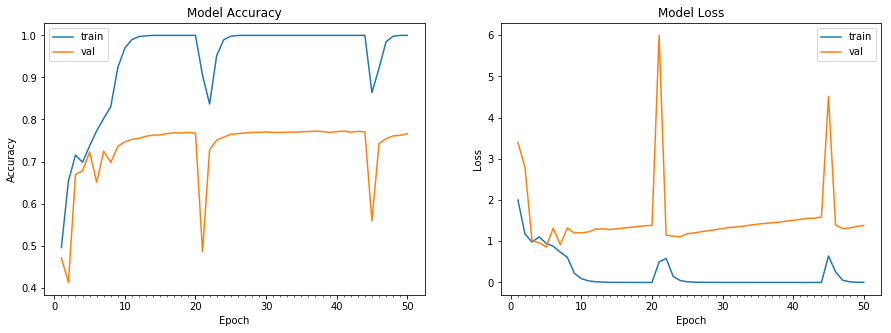

Accuracy on test data is: 76.62


In [39]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))